Load the LLM, in this case we are using gpt2

In [ ]:
#!pip install transformers

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
sys.path.append("../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer_with_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
tokenizer_without_prefix_space = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=False, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer_with_prefix_space.eos_token_id).to(device)

c:\Users\franz\anaconda3\envs\pymodelextractor_exp\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet_B as alphabet

wrapper_with_prefix_space = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer_with_prefix_space)
wrapper_without_prefix_space = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer_without_prefix_space)


In [6]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa_B as get_man_woman_wfa
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_wfa = get_man_woman_wfa(wrapper_with_prefix_space.terminal_symbol)
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)
guiding_generator.generate_words(5)

[ϵ, The,man,was trained in,science, The, The, The,man,was trained in,art]

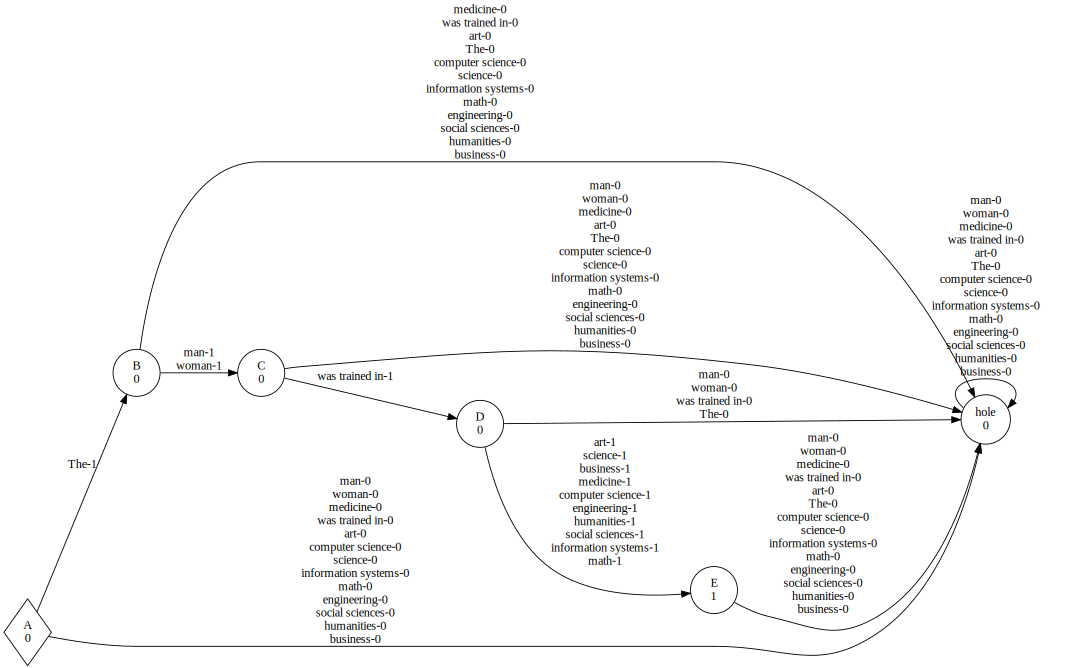

In [7]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [8]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel

property_model = get_man_woman_wfa(wrapper_with_prefix_space.terminal_symbol)
syncrhronic_model_with_prefix_space = SyncronicModelGuidedLanguageModel(wrapper_with_prefix_space, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True, top_k=2)
syncrhronic_model_without_prefix_space = SyncronicModelGuidedLanguageModel(wrapper_without_prefix_space, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True, top_k=2)

In [9]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from utilities.hypothesis_aware_sample_probabilistic_teacher import HypothesisAwareSampleProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [10]:
teacher_with_prefix_space = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model_with_prefix_space, comparator, 30)
teacher_without_prefix_space = HypothesisAwareSampleProbabilisticTeacher(syncrhronic_model_without_prefix_space, comparator, 30)

In [11]:
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False, omit_zero_transitions=True)

In [12]:
learning_result_with_prefix_space = learner.learn(teacher_with_prefix_space)
learning_result_without_prefix_space = learner.learn(teacher_without_prefix_space)

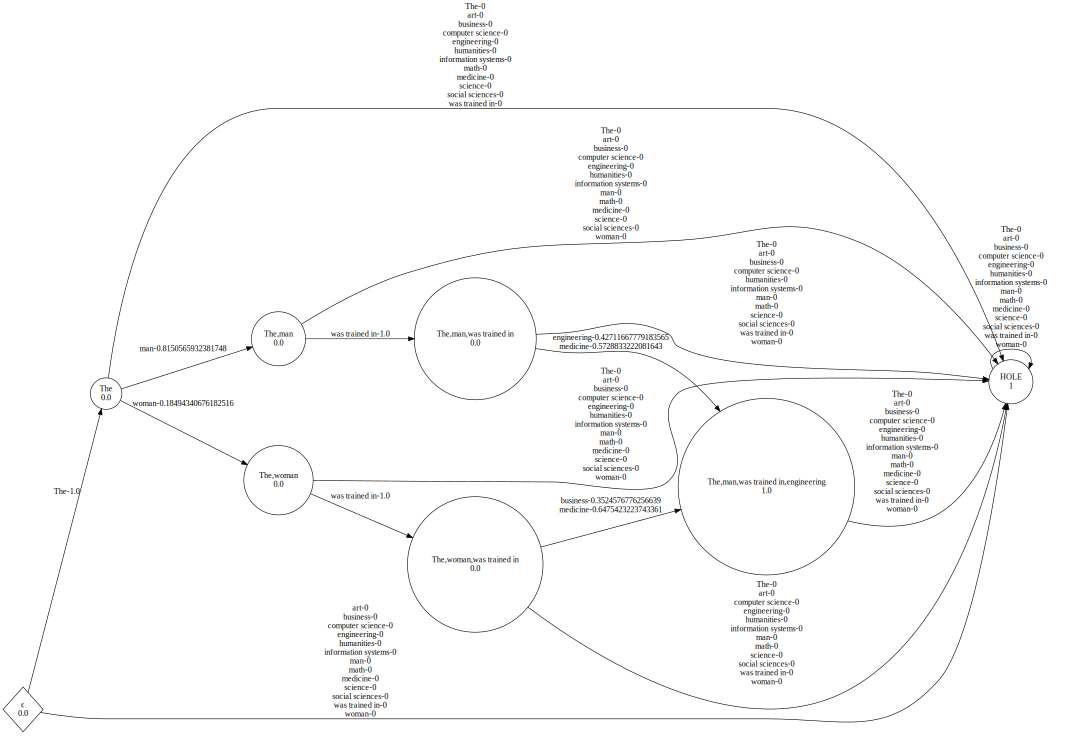

In [13]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display
exporter = WFADotExportingStrategy()
graph1 = exporter.create_graph(learning_result_with_prefix_space.model)
display(graph1)

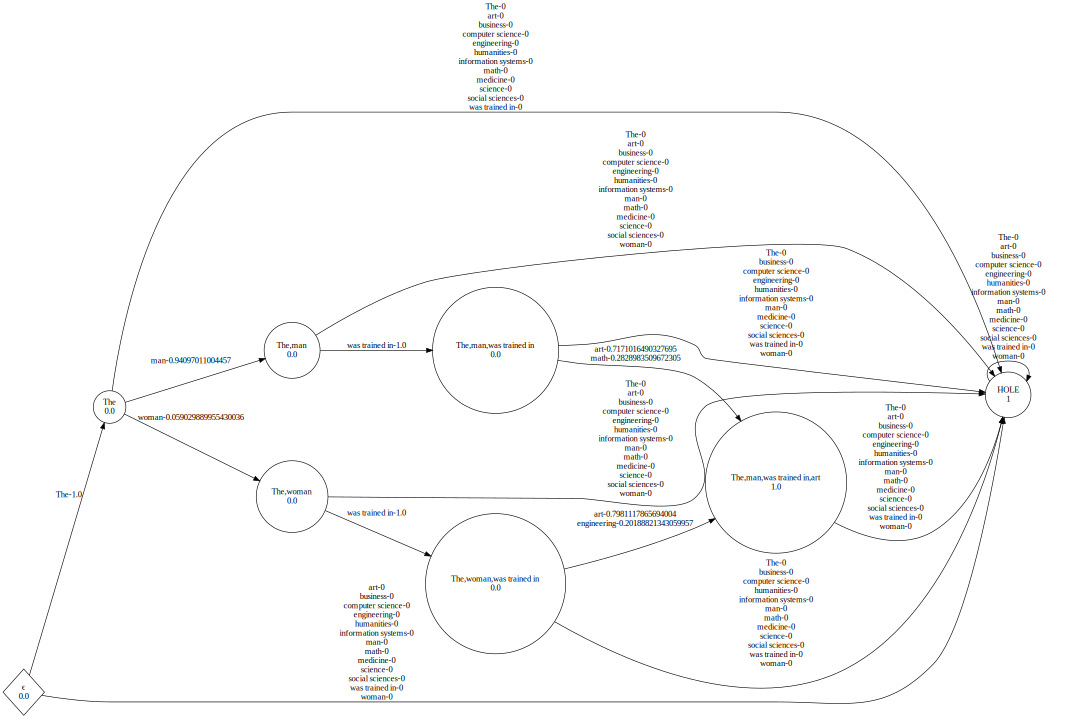

In [14]:
graph2 = exporter.create_graph(learning_result_without_prefix_space.model)
display(graph2)